In [3]:
!pip install vit_keras

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from vit_keras import vit
from vit_keras import visualize
import seaborn as sns
from PIL import Image

import math
import random
import cv2
import os
import time
import warnings

warnings.filterwarnings('ignore')

# **Define Methods**

In [5]:
def build_vit_model(vit_function, image_size, num_classes, dense_neuron, rate, activation, freeze_base_model=False):
    """
    Build and compile the Vision Transformer model.

    Args:
    - vit_function: Use a base model from vit_keras (example: vit.vit_b32 or vit.vit_b16).
    - image_size: Size of the input images.
    - num_classes: Number of classes for classification.
    - rate: Learning rate for the optimizer.
    - activation: Activation function for the dense layer.

    Returns:
    - Compiled Keras model.
    """
    vit_model = Sequential()
    
    #Initialize the ViT model
    vit_init = vit_function(
        image_size=image_size,
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
        classes=num_classes,
        weights="imagenet21k"
    )
    
    vit_init.trainable = not freeze_base_model
    if freeze_base_model:
        learning_rate = 0.001

    #Layers for the classification
    vit_model.add(vit_init)
    vit_model.add(Dense(dense_neuron, activation=activation, name=f'dense_layer_{dense_neuron}'))
    vit_model.add(Dense(num_classes, activation="softmax", name='output_layer'))

    
    adam_optimizer = Adam(learning_rate=rate)
    vit_model.compile(optimizer=adam_optimizer, loss="categorical_crossentropy",  metrics=['accuracy'])
    vit_model.summary()

    return vit_model


In [6]:
def train_model(model, train_generator, validation_generator, steps_per_epoch, validation_steps, epochs, gpu_device='/gpu:0'):
    """
    Train a model.

    Args:
    - model: Compiled model to be trained.
    - train_generator: Training data generator.
    - validation_generator: Validation data generator.
    - steps_per_epoch: Number of steps per epoch for training.
    - validation_steps: Number of steps per epoch for validation.
    - epochs: Number of epochs to train the model for.
    - gpu_device: GPU device to be used for training (default is '/gpu:0').

    Returns:
    - Training history object.
    """
    callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.01,
        patience = 5, 
        restore_best_weights = True, 
        verbose = 1
    )
    
    start = time.time()
    with tf.device(gpu_device):
        history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=validation_steps,
            callbacks=callback,
            use_multiprocessing=True, 
            workers=4  #Virutal Workers on Kaggle
        )
    stop = time.time()
    print(f'Training on GPU took: {(stop - start) / 60} minutes')

    return history



In [7]:
def evaluate_and_plot(model, validation_generator, history):
    """
    Evaluate the model, plot the confusion matrix and training curves.

    Args:
    - model: Trained Keras model.
    - test_generator: Generator to extract the classes and use a random test image for classification.
    - history: Training history object.
    """
    #Predictions and true classes
    predicted_classes = np.argmax(model.predict(validation_generator, steps=validation_generator.n // validation_generator.batch_size + 1), axis=1)
    true_classes = validation_generator.classes

    #Reverse mapping from index to class name
    index_to_class = {v: k for k, v in validation_generator.class_indices.items()}
    # Sort class labels to match the order of the class indices
    sorted_class_labels = [index_to_class[idx] for idx in sorted(index_to_class)]

    #Confusion Matrix
    confusionmatrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusionmatrix, cmap='Blues', annot=True, fmt='d', cbar=True, xticklabels=sorted_class_labels, yticklabels=sorted_class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    #Classification Report
    print(classification_report(true_classes, predicted_classes, target_names=sorted_class_labels))

    #Training Curves
    epochs = len(history.epoch)
    accuracy = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)

    #Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


In [8]:
def attention_map(model, img_path, generator):
    """
    Extract the attention map for a ViT model run with a random image.

    Args:
    - model: A ViT model from vit_keras.
    - img_path: Path to the images to be tested, includes subfolders.
    - generator: Generator to extract the classes for classification.
    """
    
    #Extract ViT model out of the Sequential for the attention_map function
    base_model = model.get_layer(model.layers[0].name)
    predict_model = model
    
    #Get class indices and create a mapping from indices to class names
    class_indices = generator.class_indices
    index_to_class = {v: k for k, v in class_indices.items()}

    all_images = []
    for root, dirs, files in os.walk(img_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_images.append(os.path.join(root, file))

    #Select a random image from the img_path and convert it to the right format
    random_image_path = random.choice(all_images)
    print(f"Selected Image: {random_image_path}")

    #Preprocess the random image
    image = Image.open(random_image_path)
    image = image.resize((224, 224))
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image_array = np.array(image)

    image_array = image_array * (1./255)

    #Predict the class
    prediction = predict_model.predict(np.expand_dims(image_array, axis=0))
    predicted_class_name = index_to_class[np.argmax(prediction, axis=1)[0]]
    predicted_probability = np.max(prediction)
    class_indices = train_generator.class_indices

    print(f"Predicted Class: {predicted_class_name}, Probability: {predicted_probability}")

    #Generate the attention map
    attention_map = visualize.attention_map(model=base_model, image=np.array(image))

    #Power Law (gamma) transformation
    gamma = 1.5  #Value to control the enhancement
    attention_map = np.array(255 * (attention_map / 255) ** gamma, dtype='uint8')

    #Plotting
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    _ = ax1.imshow(image)
    _ = ax2.imshow(attention_map, cmap='hot')

    plt.show()


# **Start with Notebook**

In [9]:
train_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'

In [10]:
class_name=['glioma','meningioma','notumor','pituitary']
num_classes=4
epochs = 10
learning_rate = 0.0001
dense_neuron = 32 #tested 64 
batch_size = 56 #64 crashed sporaticly with ViT
activation = "relu"
adam_optimizer = Adam(learning_rate=learning_rate) #Default: 0.001 results in very bad performance for all unfrozen models
image_size = 224  #Same as Imagenet21k and to match positional Embedings for ViT (has to be a 12* size of the patch_size (patch_size is 16 for vit_b16 or vit_l16 and 32 for vit_b32 or vit_l32).) https://github.com/faustomorales/vit-keras/blob/28815edc5c24492612af726d1b2ca78295128d84/vit_keras/vit.py#L98

In [11]:
#Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    #horizontal_flip=True, #does not make sense to flip a brain
    brightness_range=[0.8, 1.2],
    rotation_range=20
)

#No data augmentation for test data
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    #color_mode='grayscale',
    color_mode='rgb', #needed for ViT
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    #color_mode='grayscale',
    color_mode='rgb', #needed for ViT
    shuffle=False
)

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
x_batch, y_batch = next(train_generator)
print(x_batch.shape)  # Should be (32, height, width, channels), using rgb because of ViT
print(y_batch.shape)  # Should be (32, 4) for categorical_crossentropy with the 4 tumor categories

In [ ]:
#Display a plot of 2 by 5 train images
images, labels = next(train_generator)
num_images = 10
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i in range(num_images):
    img = images[i]
    label = labels[i]
    label_class_index = np.argmax(label)
    label_class_name = class_name[label_class_index]

    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"Class: {label_class_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def plot_class_distribution(generator, title):
    class_indices = generator.class_indices
    class_counts = {class_name: 0 for class_name in class_indices.keys()}

    #Counting images per class
    for _, labels in generator:
        for label in labels:
            class_name = list(class_indices.keys())[list(class_indices.values()).index(np.argmax(label))]
            class_counts[class_name] += 1
        if sum(class_counts.values()) >= generator.samples:
            break

    #Calculating percentages
    total_samples = sum(class_counts.values())
    class_percentages = {class_name: (count / total_samples) * 100 for class_name, count in class_counts.items()}

    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_percentages.keys(), class_percentages.values(), color='skyblue')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{round(yval, 2)}%', va='bottom', ha='center')

    plt.xlabel('Class')
    plt.ylabel('Percentage of Images (%)')
    plt.title(title)
    plt.ylim(0, max(class_percentages.values()) + 10)
    plt.show()

#Plot for train_generator
plot_class_distribution(train_generator, 'Distribution of Images by Class in Training Dataset')

#Plot for test_generator
plot_class_distribution(test_generator, 'Distribution of Images by Class in Testing Dataset')

**Die Daten sind ausgelichen genug, keine Klassifizierung ist zu überrepräsentiert.**

# **ResNet50V2**

In [ ]:
model_resnet50 = Sequential(name='ResNet50V2')

resnet_init = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(image_size, image_size, 3), #Has to be 3 for RGB images after changing to ViT
    pooling='avg',  #Add global average pooling to reduce the dimensions and because ViT models typically use a form of global average pooling to aggregate the information from the sequence of transformer blocks into a single vector representation (often achieved through attention mechanisms).
    classes=num_classes
)
#resnet_init.trainable = False

model_resnet50.add(resnet_init)
#model_resnet50.add(Dropout(0.4))
model_resnet50.add(Dense(dense_neuron, activation = activation, name=f'dense_layer_{dense_neuron}'))
#model_resnet50.add(Dense(dense_neuron/2, activation = activation))
#model_resnet50.add(Dropout(0.2))
model_resnet50.add(Dense(num_classes, activation="softmax", name='output_layer'))  #4 classes for the output layer
adam_optimizer = Adam(learning_rate=0.0001) #With Transfer Learning this learning rate is fine
model_resnet50.compile(optimizer=adam_optimizer, loss="categorical_crossentropy", metrics=['accuracy'])

model_resnet50.summary()

Result of a ResNet50 run:

Epoch 1/10
102/102 [==============================] - 114s 632ms/step - loss: 0.2846 - accuracy: 0.8960 - val_loss: 5.3063 - val_accuracy: 0.3144

Epoch 2/10
102/102 [==============================] - 63s 601ms/step - loss: 0.0813 - accuracy: 0.9715 - val_loss: 5.3495 - val_accuracy: 0.3144

Epoch 3/10
102/102 [==============================] - 62s 596ms/step - loss: 0.0644 - accuracy: 0.9779 - val_loss: 5.2272 - val_accuracy: 0.3144

Epoch 4/10
102/102 [==============================] - 61s 584ms/step - loss: 0.0487 - accuracy: 0.9835 - val_loss: 6.7035 - val_accuracy: 0.3144

Epoch 5/10
102/102 [==============================] - 61s 578ms/step - loss: 0.0314 - accuracy: 0.9895 - val_loss: 5.9626 - val_accuracy: 0.3183

Epoch 6/10
102/102 [==============================] - 61s 585ms/step - loss: 0.0306 - accuracy: 0.9895 - val_loss: 8.3809 - val_accuracy: 0.3354

Epoch 7/10
102/102 [==============================] - 60s 573ms/step - loss: 0.0199 - accuracy: 0.9947 - val_loss: 5.8960 - val_accuracy: 0.3602

Epoch 8/10
102/102 [==============================] - 61s 576ms/step - loss: 0.0280 - accuracy: 0.9905 - val_loss: 3.3811 - val_accuracy: 0.4301

Epoch 9/10
102/102 [==============================] - 59s 564ms/step - loss: 0.0334 - accuracy: 0.9900 - val_loss: 1.4251 - val_accuracy: 0.6250

Epoch 10/10
102/102 [==============================] - 61s 582ms/step - loss: 0.0158 - accuracy: 0.9951 - val_loss: 0.1798 - val_accuracy: 0.9449

Training on GPU took: 11.100733188788096 minutes


In [ ]:
resnet50_history = train_model(
    model_resnet50,            
    train_generator,        
    test_generator,         
    steps_per_epoch,        
    validation_steps,         
    epochs
)
evaluate_and_plot(model_resnet50, test_generator, resnet50_history)

In [ ]:
model_resnet50 = Sequential(name='ResNet50V2-frozen')

resnet_init = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(image_size, image_size, 3), #Has to be 3 for RGB images after changing to ViT
    pooling='avg',  #Add global average pooling to reduce the dimensions and because ViT models typically use a form of global average pooling to aggregate the spatial information from the sequence of transformer blocks into a single vector representation (often achieved through attention mechanisms).
    classes=num_classes
)
resnet_init.trainable = False

model_resnet50.add(resnet_init)
#model_resnet50.add(Dropout(0.4))
model_resnet50.add(Dense(dense_neuron, activation = activation, name=f'dense_layer_{dense_neuron}'))
#model_resnet50.add(Dropout(0.2))
model_resnet50.add(Dense(num_classes, activation="softmax", name='output_layer'))  #4 classes for the output layer
adam_optimizer = Adam(learning_rate=0.001) #With ResNet as pure Feature Extractor this learning rate is fine
model_resnet50.compile(optimizer=adam_optimizer, loss="categorical_crossentropy", metrics=['accuracy'])

model_resnet50.summary()

In [ ]:
resnet50_history = train_model(
    model_resnet50,            
    train_generator,        
    test_generator,         
    steps_per_epoch,        
    validation_steps,         
    epochs
)
evaluate_and_plot(model_resnet50, test_generator, resnet50_history)

# **VIT**

In [ ]:
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0070.jpg'
loaded_image = image.load_img(image_path, target_size=(224, 224))
image_array = tf.expand_dims(image.img_to_array(loaded_image), 0)  
patch_size = 32 #16 for vit_b16 model, 32 for vit_b32 model

#Extract patches
patches = tf.image.extract_patches(
    images=image_array,
    sizes=[1, patch_size, patch_size, 1],
    strides=[1, patch_size, patch_size, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
)

#Reshape patches for visualization
num_patches = patches.shape[1] * patches.shape[2] #[1] is num_rows, [2] is num_cols
extracted_patches = tf.reshape(patches, [-1, patch_size, patch_size, 3])

#Calculate grid size for subplots with squareroot
grid_size = int(math.sqrt(num_patches))
if grid_size * grid_size < num_patches:
    grid_size += 1

#Create subplots
fig, axes = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(grid_size, grid_size))

#Display each patch in its subplot
for i in range(grid_size * grid_size):
    ax = axes[i // grid_size, i % grid_size]
    if i < num_patches:
        ax.imshow(tf.cast(extracted_patches[i], tf.uint8))
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
vit_b16 = build_vit_model(
    vit.vit_b16, 
    image_size, 
    num_classes, 
    dense_neuron, 
    learning_rate, 
    activation
)
vit_b16_history = train_model(
    vit_b16,            
    train_generator,        
    test_generator,         
    steps_per_epoch,        
    validation_steps,         
    epochs
)
evaluate_and_plot(vit_b16, test_generator, vit_b16_history)
attention_map(vit_b16, test_path, train_generator)

In [ ]:
attention_map(vit_b16, test_path, train_generator)

419441810/419441810 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               88045824  
                                                                 
 dense_layer_32 (Dense)      (None, 32)                24608     
                                                                 
 output_layer (Dense)        (None, 4)                 132       
                                                                 
Total params: 88070564 (335.96 MB)
Trainable params: 88070564 (335.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
102/102 [==============================] - 115s 608ms/step - loss: 0.4217 - accuracy: 0.8475 - val_loss: 0.2360 - val_accuracy: 0.9231
Epoch 2/10
102/102 [==============================] - 59s 564ms

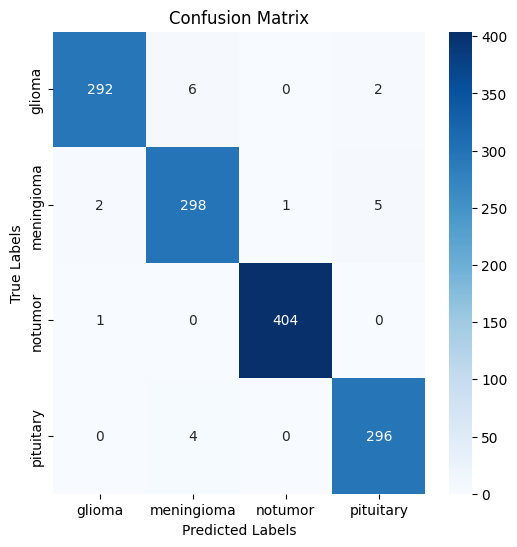

              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       300
  meningioma       0.97      0.97      0.97       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.98      0.99      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



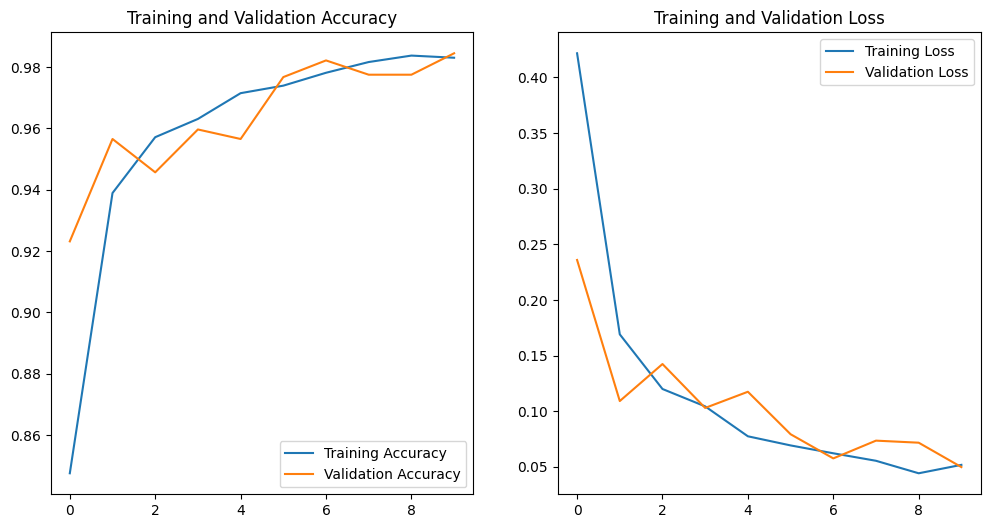

Selected Image: /kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0269.jpg
1/1 [==============================] - 3s 3s/step
Predicted Class: glioma, Probability: 0.9979015588760376
1/1 [==============================] - 3s 3s/step


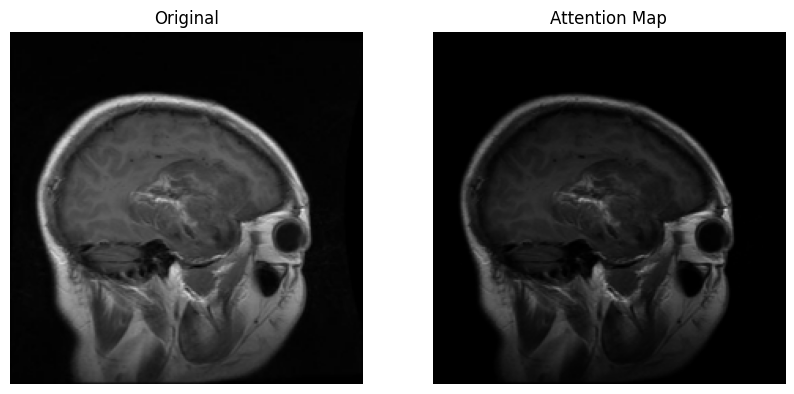

In [12]:
vit_b32 = build_vit_model(
    vit.vit_b32, 
    image_size, 
    num_classes, 
    dense_neuron, 
    learning_rate, 
    activation
)
vit_b32_history = train_model(
    vit_b32,            
    train_generator,        
    test_generator,         
    steps_per_epoch,        
    validation_steps,         
    epochs     
)
evaluate_and_plot(vit_b32, test_generator, vit_b32_history)
attention_map(vit_b32, test_path, train_generator)

Selected Image: /kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0100.jpg
1/1 [==============================] - 0s 39ms/step
Predicted Class: meningioma, Probability: 0.9955859184265137
1/1 [==============================] - 3s 3s/step


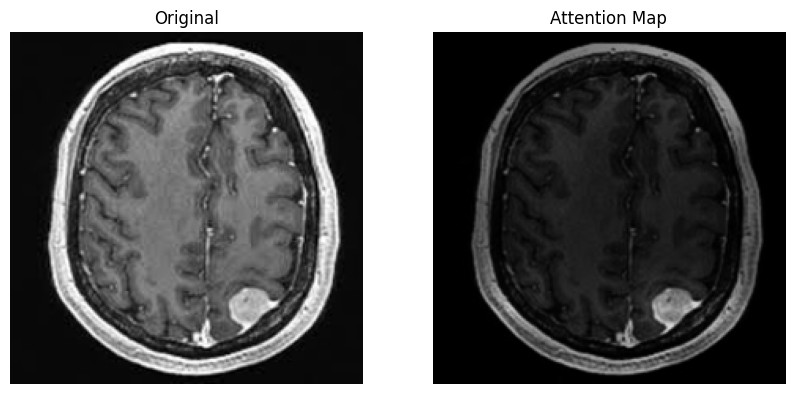

In [13]:
attention_map(vit_b32, test_path, train_generator)

Selected Image: /kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0065.jpg
1/1 [==============================] - 0s 39ms/step
Predicted Class: meningioma, Probability: 0.9978228807449341
1/1 [==============================] - 3s 3s/step


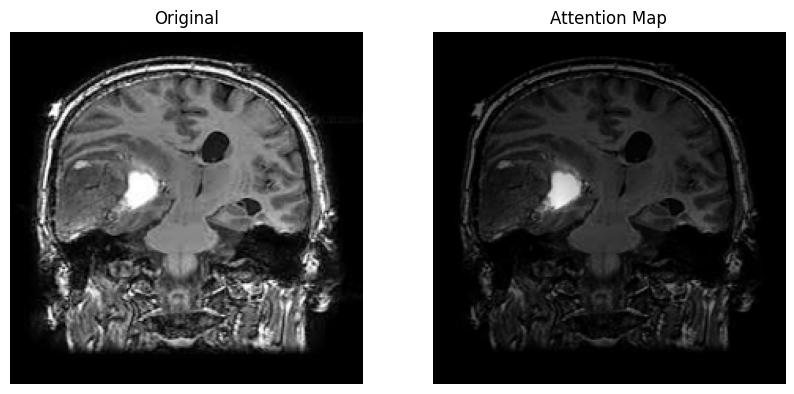

In [15]:
attention_map(vit_b32, test_path, train_generator)

Selected Image: /kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0062.jpg
1/1 [==============================] - 0s 41ms/step
Predicted Class: notumor, Probability: 0.9997773766517639
1/1 [==============================] - 3s 3s/step


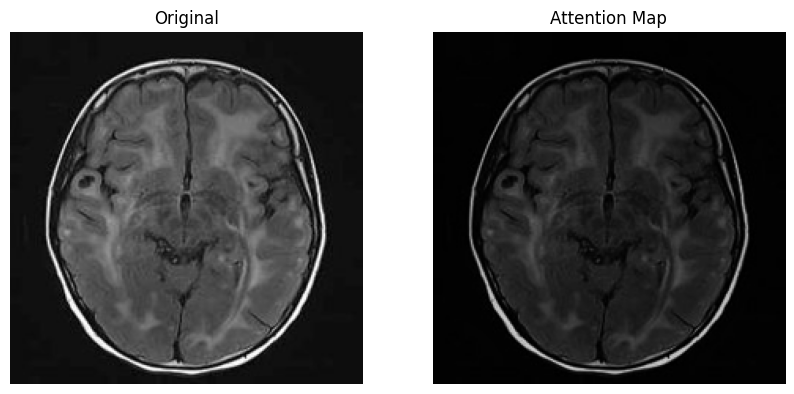

In [16]:
attention_map(vit_b32, test_path, train_generator)

Selected Image: /kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0103.jpg
1/1 [==============================] - 0s 41ms/step
Predicted Class: notumor, Probability: 0.9997904896736145
1/1 [==============================] - 3s 3s/step


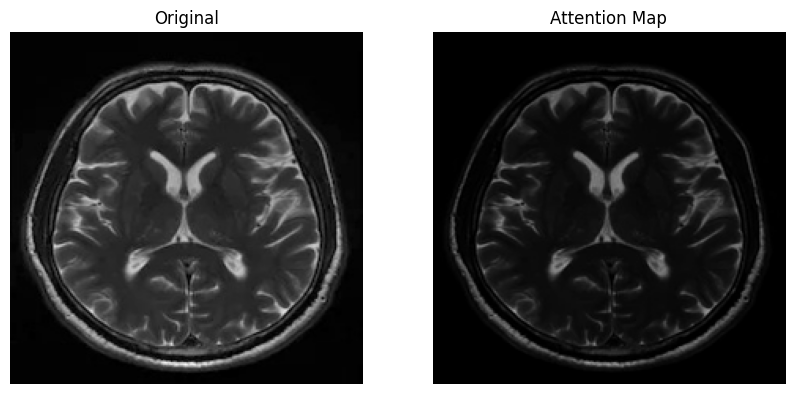

In [17]:
attention_map(vit_b32, test_path, train_generator)

Selected Image: /kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0217.jpg
1/1 [==============================] - 0s 41ms/step
Predicted Class: notumor, Probability: 0.9998261332511902
1/1 [==============================] - 3s 3s/step


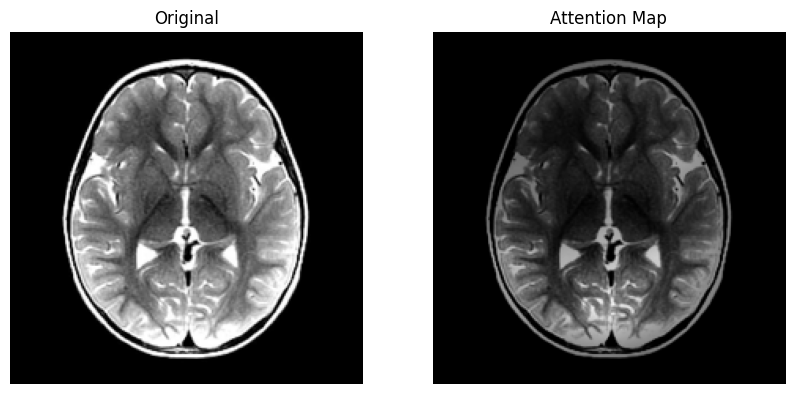

In [19]:
attention_map(vit_b32, test_path, train_generator)

In [ ]:
vit_b16_frozen = build_vit_model(
    vit.vit_b16, 
    image_size, 
    num_classes, 
    dense_neuron, 
    learning_rate, 
    activation,
    freeze_base_model=True
)
vit_b16_frozen_history = train_model(
    vit_b16_frozen,            
    train_generator,        
    test_generator,         
    steps_per_epoch,        
    validation_steps,         
    epochs
)
evaluate_and_plot(vit_b16_frozen, test_generator, vit_b16_frozen_history)
attention_map(vit_b16_frozen, test_path, train_generator)

In [ ]:
vit_b32_frozen = build_vit_model(
    vit.vit_b32, 
    image_size, 
    num_classes, 
    dense_neuron, 
    learning_rate, 
    activation,
    freeze_base_model=True
)
vit_b32_frozen_history = train_model(
    vit_b32_frozen,            
    train_generator,        
    test_generator,         
    steps_per_epoch,        
    validation_steps,         
    epochs
)
evaluate_and_plot(vit_b32_frozen, test_generator, vit_b32_frozen_history)
attention_map(vit_b32_frozen, test_path, train_generator)

In [ ]:
vit_b32_paper_model = Sequential() #Advancing Brain Tumor Classification through Fine-Tuned Vision Transformers: A Comparative Study of Pre-Trained Models

vit_b32_paper_init = vit.vit_b32(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = num_classes,
        weights = "imagenet21k"
)

vit_b32_paper_model.add(vit_b32_paper_init)
vit_b32_paper_model.add(Flatten())
vit_b32_paper_model.add(BatchNormalization())
vit_b32_paper_model.add(Dense(11, activation = activation))
vit_b32_paper_model.add(BatchNormalization())
vit_b32_paper_model.add(Dense(num_classes, activation="softmax", name="output_layer"))  #4 classes for the output layer
adam_optimizer = Adam(learning_rate=0.0001)
vit_b32_paper_model.compile(optimizer=adam_optimizer, loss="categorical_crossentropy", metrics=['accuracy'])

start = time.time()
with tf.device('/gpu:0'):
    history = vit_b32_paper_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs, 
    validation_data=test_generator,
    validation_steps=validation_steps
)
stop = time.time()
print(f'Training on GPU took: {(stop-start)/60} minutes')

In [ ]:
evaluate_and_plot(vit_b32_paper_model, test_generator, history)
attention_map(vit_b32_paper_model, test_path, train_generator)

In [ ]:
attention_map(vit_b32_model, test_path, train_generator)